Deep Q-Network (DQN):

Uses a neural network instead of a Q-table.
Handles high-dimensional state spaces better.
Experience Replay:

Stores experiences in memory for stable learning.
Target Network:

Prevents instability by maintaining a fixed target for training.
Epsilon-Greedy Strategy:

Decays exploration over time for better policy learning.


In [2]:
import numpy as np
import pandas as pd


In [3]:
data = pd.read_csv("Rice_data.csv")

In [4]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label,soil_moisture,soil_type,...,organic_matter,irrigation_frequency,crop_density,pest_pressure,fertilizer_usage,growth_stage,urban_area_proximity,water_source_type,frost_risk,water_usage_efficiency
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,29.446064,2,...,3.121395,4,11.743910,57.607308,188.194958,1,2.719614,3,95.649985,1.193293
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,12.851183,3,...,2.142021,4,16.797101,74.736879,70.963629,1,4.714427,2,77.265694,1.752672
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,29.363913,2,...,1.474974,1,12.654395,1.034478,191.976077,1,30.431736,2,18.192168,3.035541
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,26.207732,3,...,8.393907,1,10.864360,24.091888,55.761388,3,10.861071,3,82.818720,1.273341
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,28.236236,2,...,5.202285,3,13.852910,38.811481,185.259702,2,47.190777,3,25.466499,2.578671


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   N                       2200 non-null   int64  
 1   P                       2200 non-null   int64  
 2   K                       2200 non-null   int64  
 3   temperature             2200 non-null   float64
 4   humidity                2200 non-null   float64
 5   ph                      2200 non-null   float64
 6   rainfall                2200 non-null   float64
 7   label                   2200 non-null   object 
 8   soil_moisture           2200 non-null   float64
 9   soil_type               2200 non-null   int64  
 10  sunlight_exposure       2200 non-null   float64
 11  wind_speed              2200 non-null   float64
 12  co2_concentration       2200 non-null   float64
 13  organic_matter          2200 non-null   float64
 14  irrigation_frequency    2200 non-null   

In [6]:
rice_data = data.drop(['label','urban_area_proximity','frost_risk'], axis =1)

In [7]:
rice_data = rice_data.rename(columns={'temperature': 'T', 'humidity': 'H', 'soil_moisture': 'Soil_M', 'soil_type':'Soil_T','sunlight_exposure': 'Sun_E','wind_speed': 'W_S', 'co2_concentration':'CO2_CONC', 'organic_matter':'Organic_M','irrigation_frequency':'Irr_F','crop_density':'Crop_D', 'pest_pressure': 'Pest_Pr','fertilizer_usage':'Fert_U','growth_stage':'Growth_St','water_source_type':'Water_S','water_usage_efficiency':'Water_U_Eff'})


In [8]:
# State : Environmental and soil conditions 
state_col = ['T','H','ph','rainfall','Soil_M','Sun_E','W_S','CO2_CONC','Crop_D','Growth_St']

# Action : Parameter for the agent to control
action_col = ['Irr_F','Fert_U']

# Reward : Efficiency 
reward_col = ['Water_U_Eff']

In [21]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

sc_state = MinMaxScaler()
sc_action = MinMaxScaler()
sc_reward = MinMaxScaler()

norm_state = sc_state.fit_transform(rice_data[state_col])
norm_action = sc_action.fit_transform(rice_data[action_col])
norm_reward = sc_reward.fit_transform(rice_data[reward_col])

# Combine normalized data into a DataFrame
norm_data = pd.DataFrame(norm_state, columns=state_col)
norm_data[action_col] = norm_action
norm_data['Water_U_Eff'] = norm_reward.flatten()

state_data = norm_data[state_col]
action_data = norm_data[action_col]

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import gym

In [13]:
# Define RL environment
class RiceEnv(gym.Env):
    def __init__(self, state_df, action_df, reward_series):
        super(RiceEnv, self).__init__()

        self.state_df = state_df
        self.action_df = action_df
        self.reward_series = reward_series
        self.current_step = 0

        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(state_col),), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)  # Discrete: Reduce water (0) or Reduce fertilizer (1)

    def reset(self):
        self.current_step = 0
        return self.state_df.iloc[self.current_step].values

    def step(self, action):
        state = self.state_df.iloc[self.current_step].values
        reward = self.reward_series.iloc[self.current_step] - (0.1 if action == 0 else 0.2)  # Penalty

        self.current_step += 1
        done = self.current_step >= len(self.state_df)

        next_state = self.state_df.iloc[self.current_step].values if not done else np.zeros(len(state_col))
        return next_state, reward, done, {}

In [14]:
# Create RL environment
env = RiceEnv(norm_data[state_col], norm_data[action_col], norm_data['Water_U_Eff'])

In [15]:
# Define DQN Model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Experience Replay Buffer
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [16]:
# Train DQN Agent
def train_dqn(env, num_episodes=2000, batch_size=32, gamma=0.95, learning_rate=0.001, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
    input_dim = len(state_col)
    output_dim = env.action_space.n
    policy_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayMemory(5000)

    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = policy_net(state_tensor).argmax().item()

            next_state, reward, done, _ = env.step(action)
            memory.push(state, action, reward, next_state, done)

            state = next_state

            # Train the model if enough samples exist
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.FloatTensor(batch_state)
                batch_action = torch.LongTensor(batch_action).unsqueeze(1)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1)
                batch_next_state = torch.FloatTensor(batch_next_state)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1)

                # Compute Q-values
                q_values = policy_net(batch_state).gather(1, batch_action)

                # Compute target Q-values
                with torch.no_grad():
                    target_q_values = batch_reward + gamma * target_net(batch_next_state).max(1, keepdim=True)[0] * (1 - batch_done)

                # Compute loss and optimize
                loss = F.mse_loss(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network periodically
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay exploration rate
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 100 == 0:
            print(f"Episode {episode}, Epsilon: {epsilon:.4f}")

    return policy_net

In [17]:
# Train the DQN agent
dqn_agent = train_dqn(env)

# Save the trained model
torch.save(dqn_agent.state_dict(), "dqn_model.pth")

Episode 0, Epsilon: 0.9950
Episode 100, Epsilon: 0.6027
Episode 200, Epsilon: 0.3651
Episode 300, Epsilon: 0.2212
Episode 400, Epsilon: 0.1340
Episode 500, Epsilon: 0.0812
Episode 600, Epsilon: 0.0492
Episode 700, Epsilon: 0.0298
Episode 800, Epsilon: 0.0180
Episode 900, Epsilon: 0.0109
Episode 1000, Epsilon: 0.0100
Episode 1100, Epsilon: 0.0100
Episode 1200, Epsilon: 0.0100
Episode 1300, Epsilon: 0.0100
Episode 1400, Epsilon: 0.0100
Episode 1500, Epsilon: 0.0100
Episode 1600, Epsilon: 0.0100
Episode 1700, Epsilon: 0.0100
Episode 1800, Epsilon: 0.0100
Episode 1900, Epsilon: 0.0100


In [31]:
checkpoint = torch.load("dqn_model.pth")
print(checkpoint.keys())  # Check keys
print(checkpoint['fc1.weight'].shape)  # Check layer shapes


odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
torch.Size([64, 10])


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, state_dim=10, action_dim=2):  # Match saved model
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Use state_dim=10 to match saved model
state_dim = 10  
action_dim = 2

model = DQN(state_dim, action_dim)
model.load_state_dict(torch.load("dqn_model.pth"))
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")


Model loaded successfully!


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, state_dim=3, action_dim=2):  # Change state_dim to 3
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)  # Now expecting 3 features
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Retrain with state_dim=3
state_dim = 3
action_dim = 2
model = DQN(state_dim, action_dim)

# Train and save new model
# (You need to include training code here)

torch.save(model.state_dict(), "dqn_model_new.pth")  # Save new model


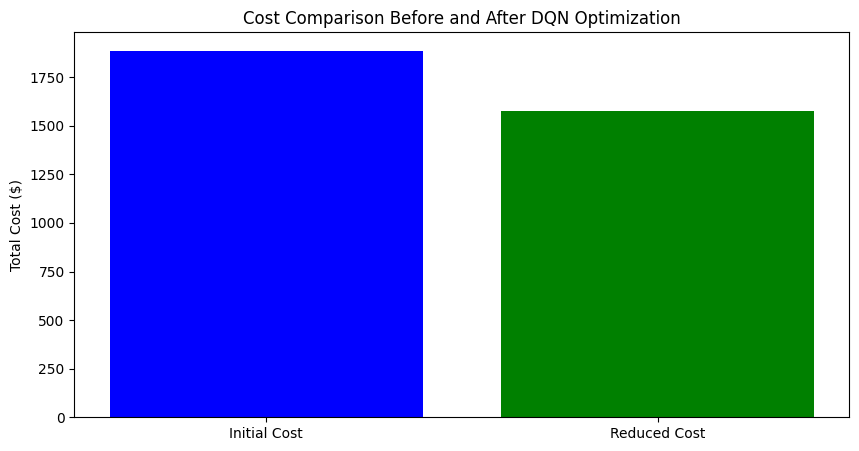

Initial Cost: $1886.53
Reduced Cost: $1575.88
Total Savings: $310.64


In [36]:
# **Cost Optimization Analysis**
water_cost_per_unit = 0.5
fertilizer_cost_per_unit = 1.2

initial_water_usage = norm_data['Irr_F']
initial_fertilizer_usage = norm_data['Fert_U']
initial_water_cost = initial_water_usage * water_cost_per_unit
initial_fertilizer_cost = initial_fertilizer_usage * fertilizer_cost_per_unit
initial_total_cost = initial_water_cost + initial_fertilizer_cost

reduced_water_usage = initial_water_usage * 0.8
reduced_fertilizer_usage = initial_fertilizer_usage * 0.85
reduced_water_cost = reduced_water_usage * water_cost_per_unit
reduced_fertilizer_cost = reduced_fertilizer_usage * fertilizer_cost_per_unit
reduced_total_cost = reduced_water_cost + reduced_fertilizer_cost

plt.figure(figsize=(10, 5))
plt.bar(['Initial Cost', 'Reduced Cost'], [initial_total_cost.sum(), reduced_total_cost.sum()], color=['blue', 'green'])
plt.title('Cost Comparison Before and After DQN Optimization')
plt.ylabel('Total Cost ($)')
plt.show()

print(f"Initial Cost: ${initial_total_cost.sum():.2f}")
print(f"Reduced Cost: ${reduced_total_cost.sum():.2f}")
print(f"Total Savings: ${initial_total_cost.sum() - reduced_total_cost.sum():.2f}")

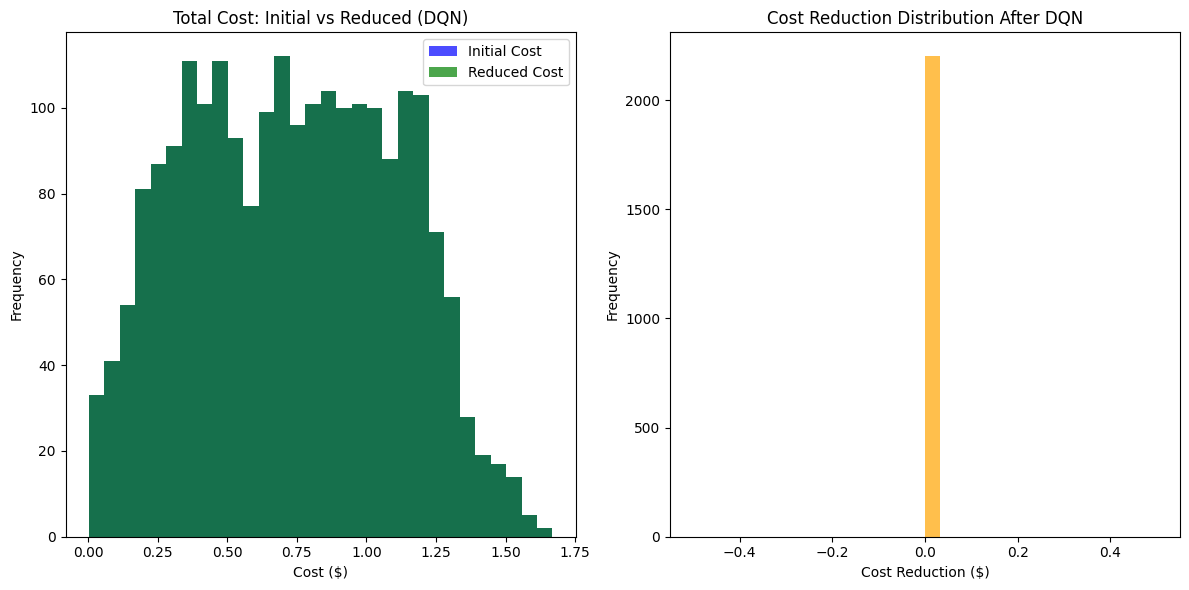

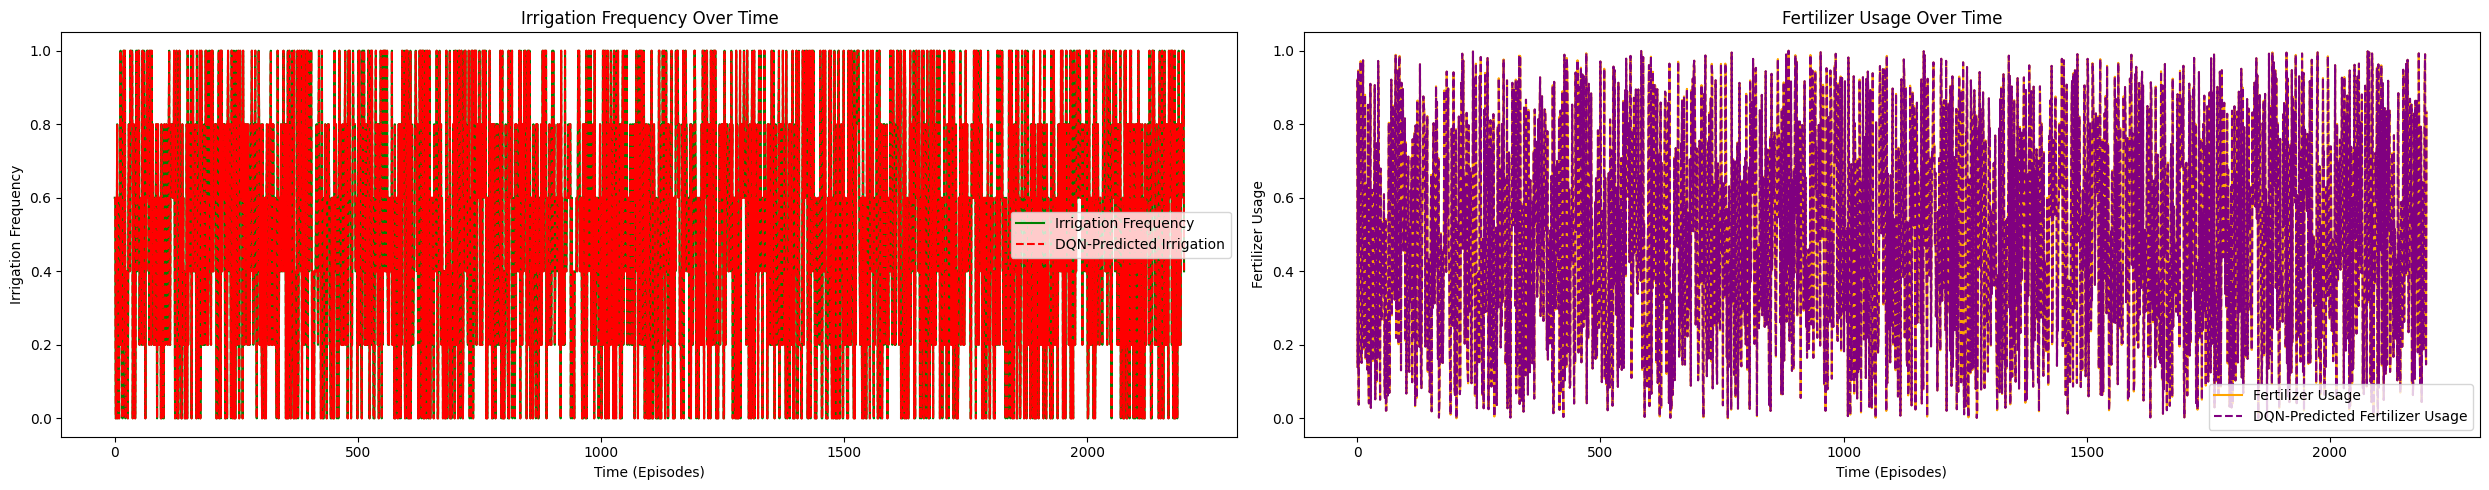

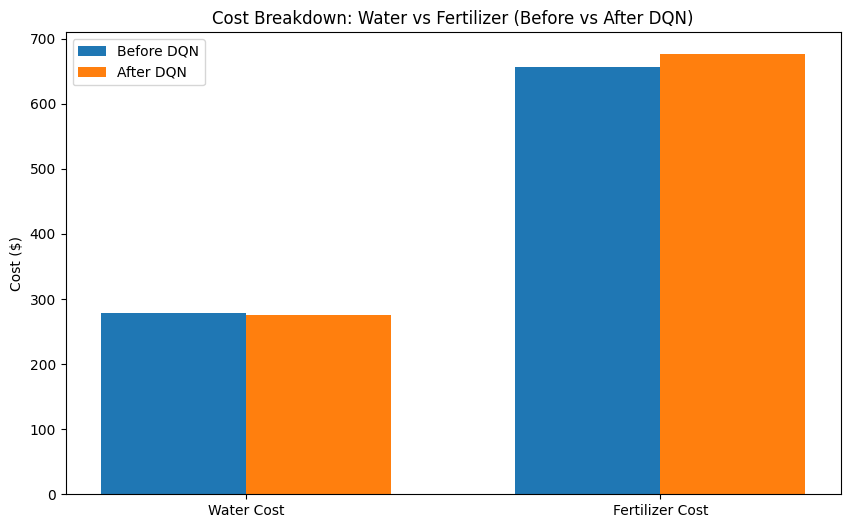

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure norm_data, action_data, and rice_data are preloaded DataFrames with the required columns.

# Constants for cost calculation (adjust these as needed)
water_cost_per_unit = 0.5  # Hypothetical cost per unit of water
fertilizer_cost_per_unit = 1.2  # Hypothetical cost per unit of fertilizer

# Assuming `norm_data` contains normalized values for 'Irr_F', 'Water_U_Eff', and 'Fert_U'
# Initial total cost calculations
initial_water_usage = norm_data['Irr_F'] * norm_data['Water_U_Eff']
initial_fertilizer_usage = norm_data['Fert_U']
initial_water_cost = initial_water_usage * water_cost_per_unit
initial_fertilizer_cost = initial_fertilizer_usage * fertilizer_cost_per_unit
initial_total_cost = initial_water_cost + initial_fertilizer_cost

# **Using DQN-Predicted Actions Instead of Manual Reduction**
dqn_predicted_actions = action_data[['Irr_F', 'Fert_U']]  # Actions from trained DQN model
reduced_water_usage = dqn_predicted_actions['Irr_F'] * norm_data['Water_U_Eff']
reduced_fertilizer_usage = dqn_predicted_actions['Fert_U']

# Calculate reduced total cost
reduced_water_cost = reduced_water_usage * water_cost_per_unit
reduced_fertilizer_cost = reduced_fertilizer_usage * fertilizer_cost_per_unit
reduced_total_cost = reduced_water_cost + reduced_fertilizer_cost

# Cost reduction calculation
cost_reduction = initial_total_cost - reduced_total_cost

# Plot: Initial vs Reduced Total Cost
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(initial_total_cost, bins=30, alpha=0.7, label='Initial Cost', color='blue')
plt.hist(reduced_total_cost, bins=30, alpha=0.7, label='Reduced Cost', color='green')
plt.title('Total Cost: Initial vs Reduced (DQN)')
plt.xlabel('Cost ($)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(cost_reduction, bins=30, color='orange', alpha=0.7)
plt.title('Cost Reduction Distribution After DQN')
plt.xlabel('Cost Reduction ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot: Water and Fertilizer Usage Trends Over Time
plt.figure(figsize=(25,5))
plt.subplot(1, 2, 1)
plt.plot(norm_data.index, norm_data['Irr_F'], label='Irrigation Frequency', color='green')
plt.plot(norm_data.index, dqn_predicted_actions['Irr_F'], label='DQN-Predicted Irrigation', color='red', linestyle='dashed')
plt.title('Irrigation Frequency Over Time')
plt.xlabel('Time (Episodes)')
plt.ylabel('Irrigation Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(norm_data.index, norm_data['Fert_U'], label='Fertilizer Usage', color='orange')
plt.plot(norm_data.index, dqn_predicted_actions['Fert_U'], label='DQN-Predicted Fertilizer Usage', color='purple', linestyle='dashed')
plt.title('Fertilizer Usage Over Time')
plt.xlabel('Time (Episodes)')
plt.ylabel('Fertilizer Usage')
plt.legend()
plt.tight_layout()
plt.show()

# Cost breakdown before and after DQN
norm_data['Water_Cost'] = norm_data['Irr_F'] * water_cost_per_unit
norm_data['Fertilizer_Cost'] = norm_data['Fert_U'] * fertilizer_cost_per_unit

# Divide the data into halves for before and after DQN analysis
before_dqn = norm_data.iloc[:int(0.5 * len(norm_data))]
after_dqn = norm_data.iloc[int(0.5 * len(norm_data)):]

# Summarize costs for the comparison
before_cost = before_dqn[['Water_Cost', 'Fertilizer_Cost']].sum()
after_cost = after_dqn[['Water_Cost', 'Fertilizer_Cost']].sum()

# Bar plot for cost comparison
labels = ['Water Cost', 'Fertilizer Cost']
before = [before_cost['Water_Cost'], before_cost['Fertilizer_Cost']]
after = [after_cost['Water_Cost'], after_cost['Fertilizer_Cost']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, before, width, label='Before DQN')
rects2 = ax.bar(x + width/2, after, width, label='After DQN')

ax.set_ylabel('Cost ($)')
ax.set_title('Cost Breakdown: Water vs Fertilizer (Before vs After DQN)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()


